In [134]:
# Cell 2 - imports and load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import random

# ML libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# load weekly aggregated data (adjust path if needed)
PATH = "aggregated_data/weekly_features.csv"   # adjust if your file is elsewhere
df = pd.read_csv(PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

DATE_COL = "Date"
TARGET_COL = "total_sales"

print("Loaded", PATH, "rows:", len(df))
display(df.head(3))


Loaded aggregated_data/weekly_features.csv rows: 65


,Date,total_sales,n_orders,total_quantity,avg_unit_price,avg_session_duration,avg_pages_viewed,pct_returning,avg_discount_amount,has_discount_rate,...,avg_qty_per_order,unique_customers,orders_per_customer,returning_times_session,discountrate_times_qty,category_share_Electronics,category_share_Home & Garden,category_share_Sports,category_share_Fashion,category_share_Toys
0,2023-01-02,80246.01,67,193,415.496119,14.388060,9.044776,0.582090,43.464328,0.417910,...,2.880597,67,1.000000,8.375139,1.203832,0.519320,0.190078,0.066568,0.090124,0.045320
1,2023-01-09,300235.22,254,763,448.612992,14.500000,9.031496,0.602362,57.833465,0.374016,...,3.003937,252,1.007937,8.734252,1.123520,0.419759,0.197702,0.197547,0.058083,0.042290
2,2023-01-16,281004.20,268,785,393.871791,14.425373,9.000000,0.641791,58.350000,0.402985,...,2.929104,259,1.034749,9.258075,1.180385,0.365671,0.182891,0.203321,0.116558,0.049825


In [135]:
# Cell 3 - config
MIN_HISTORY = 6        # minimum weeks required before training starts
MA_WINDOW = 5          # fallback moving-average window
SEQ_LEN = 9            # number of past steps used by GRU (adjust: 4-12 typical)
BATCH_SIZE = 8
EPOCHS = 200
PATIENCE = 12          # early stopping patience
HIDDEN_SIZE = 16
NUM_LAYERS = 1
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [136]:
# Cell 4 - metrics
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape_robust(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def me(y_true, y_pred):
    return float(np.mean(np.array(y_pred) - np.array(y_true)))


In [137]:
# Cell 5 - dataset helper and sequence creation functions

def create_sequences_from_series(arr, seq_len):
    """
    Given 1D array arr (length N), create sequences (X, y) where
    X[i] = arr[i : i+seq_len], y[i] = arr[i+seq_len]
    Returns arrays X (num_samples, seq_len), y (num_samples,)
    """
    arr = np.asarray(arr, dtype=float)
    n = len(arr)
    X, y = [], []
    for i in range(n - seq_len):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len])
    if len(X) == 0:
        return np.empty((0, seq_len)), np.empty((0,))
    return np.stack(X), np.array(y)

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        # X: (n_samples, seq_len, n_features) or (n_samples, seq_len)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32).reshape(-1,1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x, self.y[idx]


In [138]:
# Cell 6 - GRU model
class GRURegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=dropout)
        self.out = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, h = self.gru(x)  # out: (batch, seq_len, hidden)
        last = out[:, -1, :]  # take last time-step
        return self.out(last)


In [139]:
# Cell 7 - training function (returns trained model and scalers)
def train_gru(X_train, y_train, seq_len, input_size=1,
              batch_size=BATCH_SIZE, epochs=EPOCHS, patience=PATIENCE,
              lr=LEARNING_RATE, device=DEVICE):
    """
    X_train: shape (n_samples, seq_len) for univariate
    y_train: shape (n_samples,)
    Returns trained model and scalers (X_scaler, y_scaler).
    """
    # scalers: fit on X_train and y_train
    # For univariate, X_train shape (n, seq_len)
    n_samples = X_train.shape[0]
    if n_samples == 0:
        return None, None, None

    # scale X (flatten across samples and time)
    X_scaler = StandardScaler()
    X_flat = X_train.reshape(-1, 1)
    X_scaler.fit(X_flat)
    X_train_scaled = X_scaler.transform(X_flat).reshape(X_train.shape)

    y_scaler = StandardScaler()
    y_train = y_train.reshape(-1,1)
    y_scaler.fit(y_train)
    y_train_scaled = y_scaler.transform(y_train).reshape(-1)

    # split into train/val within the known history (no leakage)
    val_frac = 0.15 if n_samples > 10 else 0.2
    val_n = max(1, int(n_samples * val_frac))
    train_n = n_samples - val_n
    X_tr = X_train_scaled[:train_n]
    y_tr = y_train_scaled[:train_n]
    X_val = X_train_scaled[train_n:]
    y_val = y_train_scaled[train_n:]

    train_ds = SequenceDataset(X_tr, y_tr)
    val_ds = SequenceDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=min(batch_size, len(train_ds)), shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

    model = GRURegressor(input_size=input_size).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_model_state = None
    epochs_no_improve = 0

    for ep in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
        # validation
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                vpred = model(xb)
                vloss = loss_fn(vpred, yb).item()
        if vloss < best_val - 1e-6:
            best_val = vloss
            best_model_state = {k:v.cpu() for k,v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            break

    # load best state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, X_scaler, y_scaler


In [140]:
# Cell 8 - walk-forward training + prediction
dates = df[DATE_COL].values
y = df[TARGET_COL].values
T = len(df)

pred_rows = []
t0 = time.time()
fit_times = []

for t in range(MIN_HISTORY, T):
    history = y[:t]  # available up to t-1
    test_date = dates[t]
    test_actual = float(y[t])

    # fallback if insufficient history to construct one sequence
    if len(history) < SEQ_LEN + 1:
        # fallback to moving average (or last)
        if len(history) >= MA_WINDOW:
            pred_fallback = float(np.mean(history[-MA_WINDOW:]))
        else:
            pred_fallback = float(history[-1])  # last observed
        pred_rows.append({"Date": test_date, "actual": test_actual, "gru_pred": pred_fallback, "train_n": len(history), "status": "fallback_insufficient_history"})
        continue

    # build sequences from history
    X_all, y_all = create_sequences_from_series(history, SEQ_LEN)
    # X_all shape (n_samples, seq_len)
    if X_all.shape[0] == 0:
        # fallback
        pred_rows.append({"Date": test_date, "actual": test_actual, "gru_pred": float(history[-1]), "train_n": len(history), "status": "fallback_no_sequences"})
        continue

    # Train model on sequences
    start = time.time()
    try:
        model, X_scaler, y_scaler = train_gru(X_all, y_all, seq_len=SEQ_LEN)
        fit_time = time.time() - start
        fit_times.append(fit_time)
        if model is None:
            raise RuntimeError("Model training returned None")

        # prepare last sequence for prediction: last SEQ_LEN values from history
        last_seq = np.array(history[-SEQ_LEN:]).reshape(1, SEQ_LEN)
        last_seq_scaled = X_scaler.transform(last_seq.reshape(-1,1)).reshape(1, SEQ_LEN)
        last_seq_t = torch.tensor(last_seq_scaled, dtype=torch.float32).unsqueeze(-1).to(DEVICE)  # shape (1, seq_len, 1)
        model.eval()
        with torch.no_grad():
            yhat_scaled = model(last_seq_t).cpu().numpy().reshape(-1,1)
        yhat = y_scaler.inverse_transform(yhat_scaled)[0,0]
        pred = float(yhat)
        status = "trained"
    except Exception as e:
        # fallback to moving average if training fails
        if len(history) >= MA_WINDOW:
            pred = float(np.mean(history[-MA_WINDOW:]))
        else:
            pred = float(history[-1])
        status = f"fallback_error:{str(e)[:80]}"

    pred_rows.append({"Date": test_date, "actual": test_actual, "gru_pred": pred, "train_n": len(history), "status": status})

t_elapsed = time.time() - t0
print(f"Walk-forward completed in {t_elapsed:.1f}s, avg fit time (trained steps) ~ {np.mean(fit_times) if fit_times else float('nan'):.2f}s")


Walk-forward completed in 8.6s, avg fit time (trained steps) ~ 0.16s


In [141]:
# Cell 9 - results df and metrics
results = pd.DataFrame(pred_rows)
mask_valid = results["gru_pred"].notna()

y_true = results.loc[mask_valid, "actual"].values
y_pred = results.loc[mask_valid, "gru_pred"].values

metrics = {
    "RMSE": rmse(y_true, y_pred),
    "MAPE(%)": mape_robust(y_true, y_pred),
    "ME": me(y_true, y_pred),
    "N_preds": len(y_pred)
}
print("GRU walk-forward metrics:")
for k,v in metrics.items():
    print(f"  {k}: {v}")
results.head(10)


GRU walk-forward metrics:
  RMSE: 42465.04033057933
  MAPE(%): 9.943089421422844
  ME: -2711.328449152544
  N_preds: 59


,Date,actual,gru_pred,train_n,status
0,2023-02-13,341518.20,306923.25400,6,fallback_insufficient_history
1,2023-02-20,373824.13,315179.85000,7,fallback_insufficient_history
2,2023-02-27,311282.96,333743.83600,8,fallback_insufficient_history
3,2023-03-06,310015.78,336444.38800,9,fallback_insufficient_history
4,2023-03-13,323682.07,337609.66600,10,fallback_error:num_samples should be a positiv...
5,2023-03-20,313631.01,308955.90625,11,trained
6,2023-03-27,390888.82,317864.28125,12,trained
7,2023-04-03,320561.13,314810.34375,13,trained
8,2023-04-10,318879.66,359718.81250,14,trained
9,2023-04-17,456454.26,333642.75000,15,trained


In [142]:
# Cell 10 - moving average baseline on same evaluation points
ma_preds = []
for i, row in results.iterrows():
    date = row["Date"]
    idx = df.index[df[DATE_COL] == date][0]
    if idx >= MA_WINDOW:
        ma_pred = float(np.mean(df.loc[idx-MA_WINDOW:idx-1, TARGET_COL].values))
    else:
        ma_pred = float(df.loc[:idx-1, TARGET_COL].iloc[-1])
    ma_preds.append(ma_pred)

results["moving_avg"] = ma_preds

y_pred_ma = results["moving_avg"].values
metrics_ma = {"RMSE": rmse(y_true, y_pred_ma), "MAPE(%)": mape_robust(y_true, y_pred_ma), "ME": me(y_true, y_pred_ma)}
print("Moving-average metrics on same evaluation points:")
for k,v in metrics_ma.items():
    print(f"  {k}: {v}")


Moving-average metrics on same evaluation points:
  RMSE: 44615.48640953907
  MAPE(%): 10.384119580713037
  ME: -1616.1655932203394


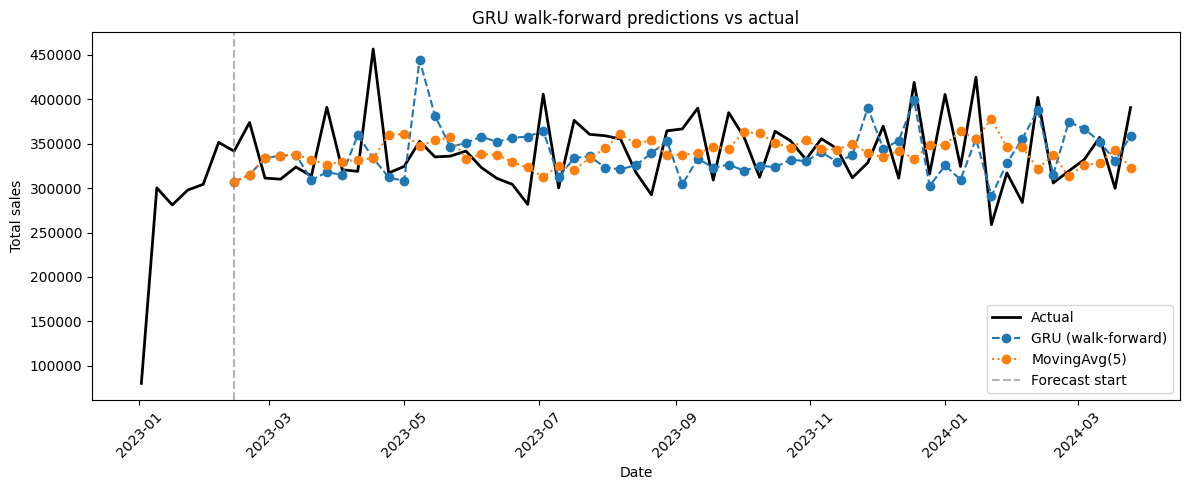

In [143]:
# Cell 11 - visualization
plt.figure(figsize=(12,5))
plt.plot(df[DATE_COL], df[TARGET_COL], label="Actual", color="black", linewidth=2)
plt.plot(results["Date"], results["gru_pred"], label="GRU (walk-forward)", marker="o", linestyle="--")
plt.plot(results["Date"], results["moving_avg"], label=f"MovingAvg({MA_WINDOW})", marker="o", linestyle=":")
plt.axvline(results["Date"].iloc[0], color="grey", linestyle="--", alpha=0.6, label="Forecast start")
plt.xlabel("Date")
plt.ylabel("Total sales")
plt.title("GRU walk-forward predictions vs actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [144]:
# Cell 12 - save predictions
results.to_csv("w5_gru_walk_forward_predictions.csv", index=False)
print("Saved gru_walk_forward_predictions.csv")


Saved gru_walk_forward_predictions.csv
